In [1]:
%cd ~/../kaggle/working
!git clone https://github.com/RSourceCode/SAM2.git

/kaggle/working
Cloning into 'SAM2'...
remote: Enumerating objects: 1069, done.
remote: Total 1069 (delta 0), reused 0 (delta 0), pack-reused 1069 (from 1)
Receiving objects: 100% (1069/1069), 128.56 MiB | 34.31 MiB/s, done.
Resolving deltas: 100% (360/360), done.


In [2]:
%cd SAM2
!pip install sam2
!pip install -e .

/kaggle/working/SAM2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 3.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
  

In [3]:
%cd checkpoints
!bash download_ckpts.sh
%cd ../notebooks

/kaggle/working/SAM2/checkpoints
--2025-07-07 06:47:27--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.72, 18.164.78.121, 18.164.78.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   168MB/s    in 0.9s    

2025-07-07 06:47:28 (168 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-07-07 06:47:28--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.121, 18.164.78.81, 18.164.78.72, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.121|:443... connected.
HTTP request sent, awaiting response... 200 

In [4]:
###### imports ########
import os
import numpy as np
import cv2
import urllib.request
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

using device: cpu


In [6]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('on')
        plt.show()


def imread_from_url(url):
    try:
        req = urllib.request.urlopen(url)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, -1)
        return img
    except Exception as e:
        print(f"Error reading image from URL: {e}")
        return None


In [7]:
sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

## Test Image 1 : Cat

In [8]:
image = imread_from_url("https://t3.ftcdn.net/jpg/02/36/99/22/360_F_236992283_sNOxCVQeFLd5pdqaKGh8DRGMZy7P4XKm.jpg");
image = image.copy()
# Resize image to maximum size of 1024

r = np.min([1024 / image.shape[1], 1024 / image.shape[0]])
image = cv2.resize(image, (int(image.shape[1] * r), int(image.shape[0] * r)))

predictor.set_image(image)

In [9]:
# predict mask
input_points = np.array([[[[350,520]]],[[[600,360]]],[[[470,480]]]])
input_labels = np.array([[1], [1], [1]])
prd_masks = []
for i in range(len(input_points)):
    masks, scores, logits = predictor.predict(
        point_coords=input_points[i][0],
        point_labels=input_labels[i],
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    prd_masks.append(masks[0])

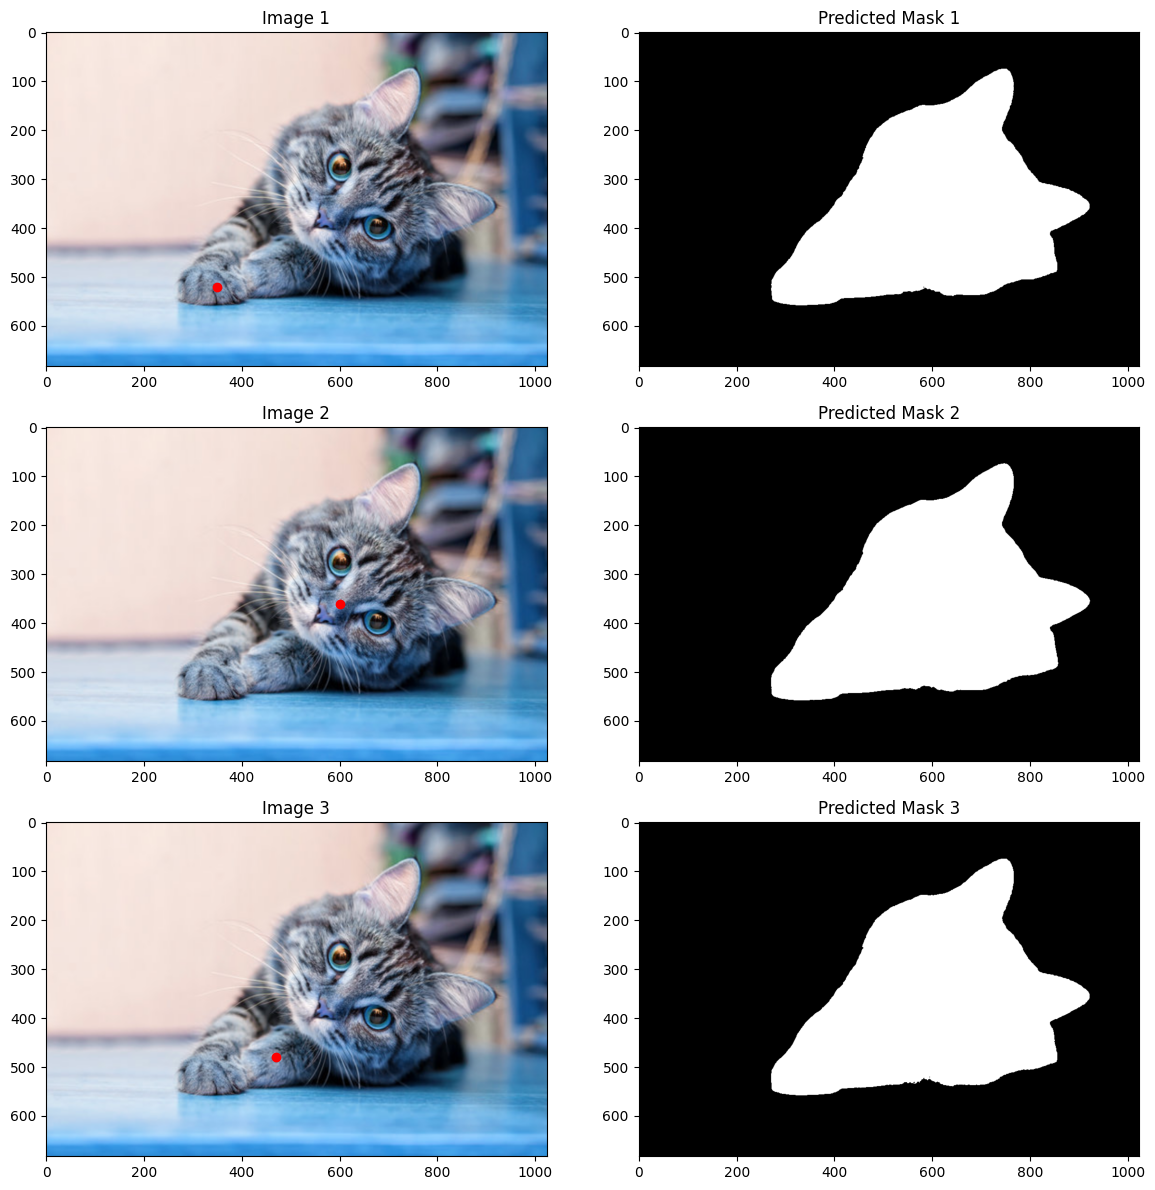

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten for easier indexing (0 to 7)

for i in range(3):
    # Plot original image with red point
    axes[2*i].imshow(image)  # Convert BGR to RGB
    axes[2*i].scatter(input_points[i][0][0][0], input_points[i][0][0][1], color='red')
    axes[2*i].set_title(f"Image {i+1}")
    axes[2*i].axis('on')

    # Plot predicted mask
    axes[2*i + 1].imshow(prd_masks[i], cmap='gray')
    axes[2*i + 1].set_title(f"Predicted Mask {i+1}")
    axes[2*i + 1].axis('on')

plt.tight_layout()
plt.show()

## Test Image 2 : Car

In [11]:
image = imread_from_url("https://i.ebayimg.com/00/s/NTMxWDgwMA==/z/4IEAAOSw5utabG72/$_86.JPG");
image = image[:, :, ::-1].copy()
# Resize image to maximum size of 1024

r = np.min([1024 / image.shape[1], 1024 / image.shape[0]])
image = cv2.resize(image, (int(image.shape[1] * r), int(image.shape[0] * r)))

predictor.set_image(image)

In [12]:
# predict mask
input_points = np.array([[[350,510]], [[600,410]], [[800,200]],[[380,180]],[[800,410]]])
input_labels = np.array([[1], [1], [1], [1], [1]])
prd_masks = []
for i in range(len(input_points)):
    masks, scores, logits = predictor.predict(
        point_coords=input_points[i],
        point_labels=input_labels[i],
        multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    prd_masks.append(masks[0])

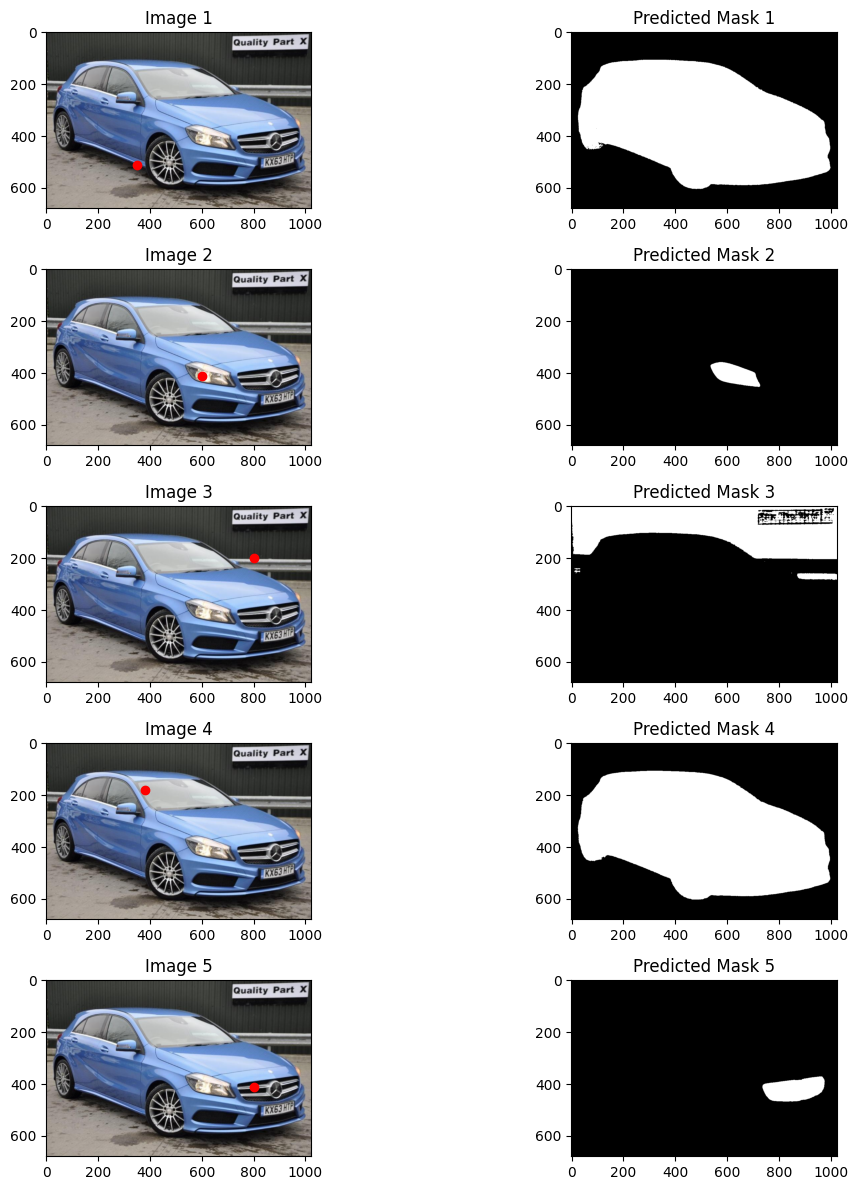

In [13]:
fig, axes = plt.subplots(len(input_points), 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten for easier indexing (0 to 7)

for i in range(len(input_points)):
    # Plot original image with red point
    axes[2*i].imshow(image)  # Convert BGR to RGB
    axes[2*i].scatter(input_points[i][0][0], input_points[i][0][1], color='red')
    axes[2*i].set_title(f"Image {i+1}")
    axes[2*i].axis('on')

    # Plot predicted mask
    axes[2*i + 1].imshow(prd_masks[i], cmap='gray')
    axes[2*i + 1].set_title(f"Predicted Mask {i+1}")
    axes[2*i + 1].axis('on')

plt.tight_layout()
plt.show()

## Test Image 3: Building

In [14]:
image = imread_from_url("https://images.brickset.com/sets/large/10182-1.jpg");
image = image[:, :, ::-1].copy()
# Resize image to maximum size of 1024

r = np.min([1024 / image.shape[1], 1024 / image.shape[0]])
image = cv2.resize(image, (int(image.shape[1] * r), int(image.shape[0] * r)))

predictor.set_image(image)

In [15]:
# predict mask
input_points = np.array([[[600,410]],[[800,410]]])
input_labels = np.array([[1], [1]])
prd_masks = []
for i in range(len(input_points)):
    masks, scores, logits = predictor.predict(
        point_coords=input_points[i],
        point_labels=input_labels[i],
        multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    prd_masks.append(masks[0])

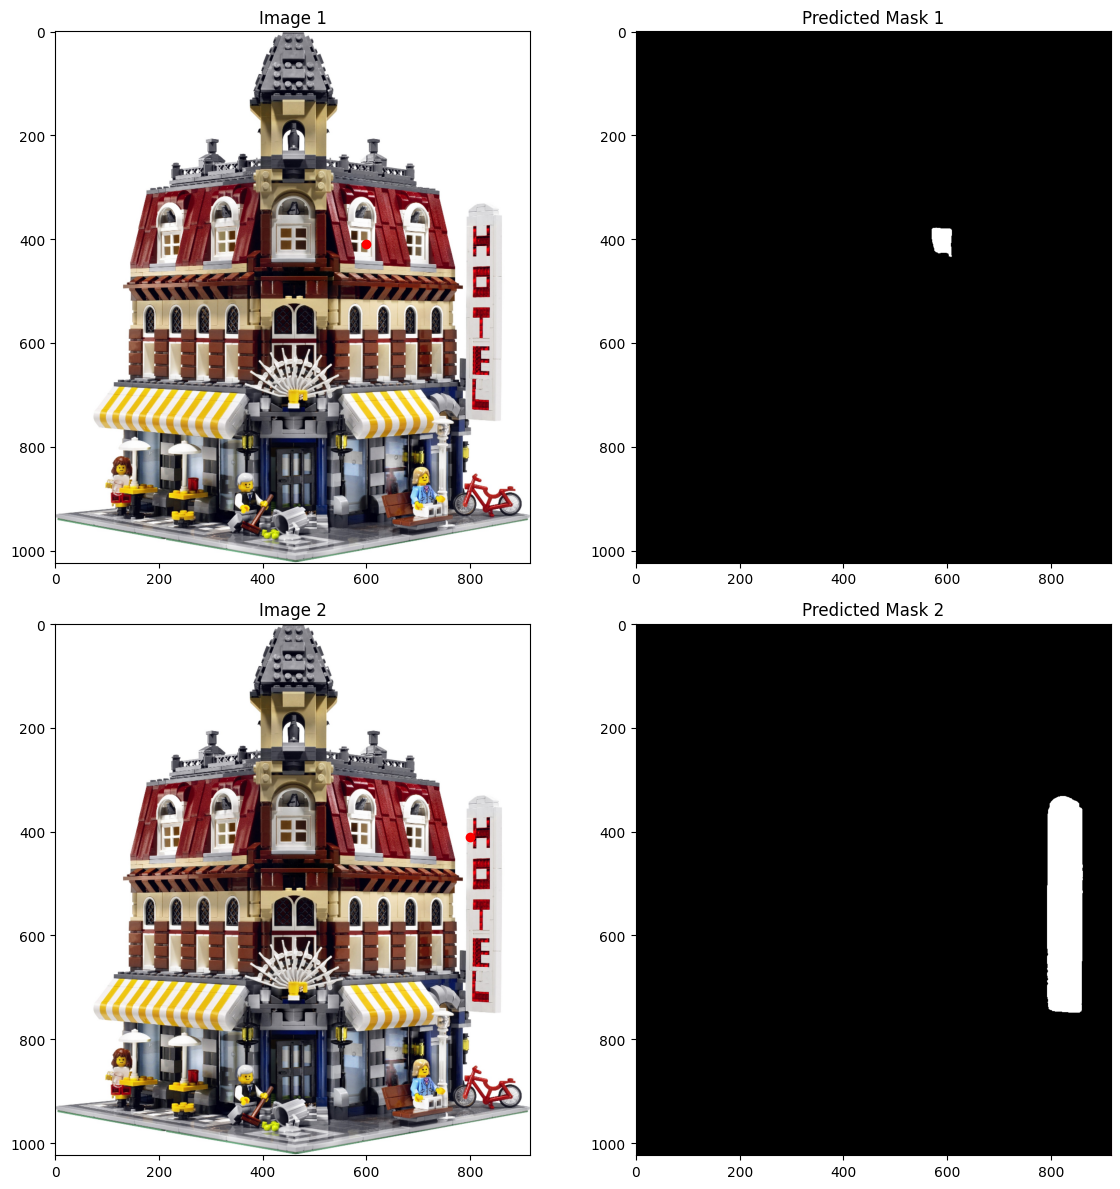

In [16]:
fig, axes = plt.subplots(len(input_points), 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten for easier indexing (0 to 7)

for i in range(len(input_points)):
    # Plot original image with red point
    axes[2*i].imshow(image)  # Convert BGR to RGB
    axes[2*i].scatter(input_points[i][0][0], input_points[i][0][1], color='red')
    axes[2*i].set_title(f"Image {i+1}")
    axes[2*i].axis('on')

    # Plot predicted mask
    axes[2*i + 1].imshow(prd_masks[i], cmap='gray')
    axes[2*i + 1].set_title(f"Predicted Mask {i+1}")
    axes[2*i + 1].axis('on')

plt.tight_layout()
plt.show()

## Test Image 4: Spinal Cord

In [17]:
image = imread_from_url("https://p.turbosquid.com/ts-thumb/8v/dUakhI/SY1wPWzZ/o5/jpg/1435082563/1920x1080/fit_q87/3ef04343d9e3f396a4599ba93116de0c0b1f0a97/o5.jpg");
image = image[:, :, ::-1].copy()
# Resize image to maximum size of 1024

r = np.min([1024 / image.shape[1], 1024 / image.shape[0]])
image = cv2.resize(image, (int(image.shape[1] * r), int(image.shape[0] * r)))

predictor.set_image(image)

In [18]:
# predict mask
input_points = np.array([[[200,600]],[[170,420]]])
input_labels = np.array([[1], [1]])
prd_masks = []
for i in range(len(input_points)):
    masks, scores, logits = predictor.predict(
        point_coords=input_points[i],
        point_labels=input_labels[i],
        multimask_output=True)
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    prd_masks.append(masks[0])

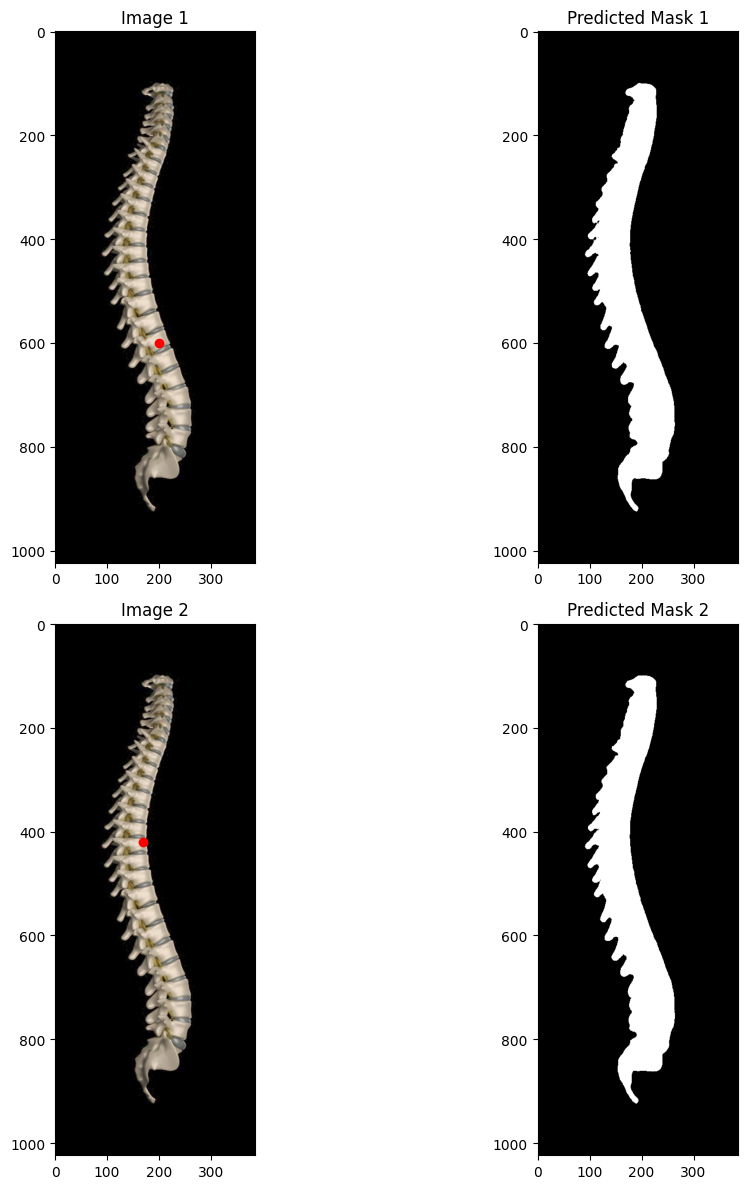

In [19]:
fig, axes = plt.subplots(len(input_points), 2, figsize=(12, 12))
axes = axes.flatten()  # Flatten for easier indexing (0 to 7)

for i in range(len(input_points)):
    # Plot original image with red point
    axes[2*i].imshow(image)  # Convert BGR to RGB
    axes[2*i].scatter(input_points[i][0][0], input_points[i][0][1], color='red')
    axes[2*i].set_title(f"Image {i+1}")
    axes[2*i].axis('on')

    # Plot predicted mask
    axes[2*i + 1].imshow(prd_masks[i], cmap='gray')
    axes[2*i + 1].set_title(f"Predicted Mask {i+1}")
    axes[2*i + 1].axis('on')

plt.tight_layout()
plt.show()